## 라이브러리 불러오기

In [7]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from itertools import permutations, combinations
from tqdm import tqdm
import warnings
import time
import random
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

## 전처리 함수 정의

In [8]:
def preprocess_none(img):
    return cv2.resize(img, (100, 100))

def preprocess_clahe(img):
    img = cv2.resize(img, (100, 100))
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

def preprocess_gamma(img, gamma=1.5):
    img = cv2.resize(img, (100, 100))
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                     for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(img, table)

def preprocess_hsv_boost(img, delta=10):  # 40에서 10으로 변경
    img = cv2.resize(img, (100, 100))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] + delta, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

def preprocess_sharpen(img):
    img = cv2.resize(img, (100, 100))
    blur = cv2.GaussianBlur(img, (0, 0), 3)
    return cv2.addWeighted(img, 1.5, blur, -0.5, 0)

def preprocess_gaussian_blur(img):
    img = cv2.resize(img, (100, 100))
    return cv2.GaussianBlur(img, (5, 5), 0.5)  # sigma를 1에서 0.5로 변경

def preprocess_circle_detect(img):
    img = cv2.resize(img, (100, 100))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
                               param1=50, param2=30, minRadius=5, maxRadius=40)
    output = img.copy()
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            cv2.circle(output, (x, y), r, (0, 255, 0), 2)
    return output

## 특징 추출 함수

In [9]:
def extract_features(image):
    """LED 특화 확장된 특징 추출 (기존 14개 + 추가 특징들)"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    features = []
    
    # === 기존 14개 특징 (호환성 유지) ===
    # 밝기 관련 특징 (3개)
    avg_brightness = np.mean(gray)
    max_brightness = np.max(gray)
    std_brightness = np.std(gray)
    features.extend([avg_brightness, max_brightness, std_brightness])

    # RGB 평균값 (3개)
    avg_b, avg_g, avg_r = cv2.mean(image)[:3]
    features.extend([avg_r, avg_g, avg_b])

    # 색상 비율 계산 (3개)
    def mask_ratio(hsv_img, lower, upper):
        mask = cv2.inRange(hsv_img, lower, upper)
        return np.count_nonzero(mask) / (mask.size + 1e-6)

    green_ratio = mask_ratio(hsv, (40, 50, 50), (85, 255, 255))
    yellow_ratio = mask_ratio(hsv, (20, 50, 50), (35, 255, 255))
    red_ratio = (
        mask_ratio(hsv, (0, 50, 50), (10, 255, 255)) +
        mask_ratio(hsv, (160, 50, 50), (180, 255, 255))
    )
    features.extend([green_ratio, yellow_ratio, red_ratio])

    # 엣지 관련 특징 (2개)
    edges = cv2.Canny(gray, 100, 200)
    edge_count = np.count_nonzero(edges)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_area = sum(cv2.contourArea(c) for c in contours)
    features.extend([edge_count, contour_area])

    # HSV 평균값 (3개)
    hue_mean = np.mean(hsv[:, :, 0])
    saturation_mean = np.mean(hsv[:, :, 1])
    value_mean = np.mean(hsv[:, :, 2])
    features.extend([hue_mean, saturation_mean, value_mean])
    
    # === LED 특화 추가 특징들 ===
    
    # 밝기 분포 특징 (4개)
    min_brightness = np.min(gray)
    brightness_range = max_brightness - min_brightness
    brightness_median = np.median(gray)
    features.extend([min_brightness, brightness_range, brightness_median])
    
    # RGB 최대값 및 비율 (6개)
    max_red = np.max(image[:,:,2])
    max_green = np.max(image[:,:,1])
    max_blue = np.max(image[:,:,0])
    rgb_dominance = np.argmax([avg_r, avg_g, avg_b])  # 0=R, 1=G, 2=B
    rg_ratio = avg_r / (avg_g + 1e-6)
    rb_ratio = avg_r / (avg_b + 1e-6)
    features.extend([max_red, max_green, max_blue, rgb_dominance, rg_ratio, rb_ratio])
    
    # HSV 확장 특징 (3개)
    hue_std = np.std(hsv[:, :, 0])
    saturation_std = np.std(hsv[:, :, 1])
    saturation_max = np.max(hsv[:, :, 1])
    features.extend([hue_std, saturation_std, saturation_max])
    
    # 색상 마스킹 확장 (3개)
    bright_pixel_ratio = mask_ratio(hsv, (0, 0, 200), (180, 255, 255))
    dark_pixel_ratio = mask_ratio(hsv, (0, 0, 0), (180, 255, 50))
    high_sat_ratio = mask_ratio(hsv, (0, 150, 50), (180, 255, 255))
    features.extend([bright_pixel_ratio, dark_pixel_ratio, high_sat_ratio])
    
    # LED 중심/가장자리 특징 (4개)
    h, w = gray.shape
    center = gray[h//4:3*h//4, w//4:3*w//4]
    edge_region = np.concatenate([gray[:h//4, :].flatten(), gray[3*h//4:, :].flatten(),
                                 gray[:, :w//4].flatten(), gray[:, 3*w//4:].flatten()])
    
    center_brightness = np.mean(center)
    edge_brightness = np.mean(edge_region)
    center_edge_ratio = center_brightness / (edge_brightness + 1e-6)
    features.extend([center_brightness, edge_brightness, center_edge_ratio])
    
    # 핫스팟 감지 (2개)
    hotspot_mask = gray > (np.max(gray) * 0.8)
    hotspot_count = np.count_nonzero(hotspot_mask)
    hotspot_ratio = hotspot_count / (gray.size + 1e-6)
    features.extend([hotspot_count, hotspot_ratio])
    
    # 색상 균일성 (1개)
    color_uniformity = 1.0 / (1.0 + np.std(hsv[:,:,0]) + np.std(hsv[:,:,1]))
    features.append(color_uniformity)
    
    return features

In [19]:
def apply_parallel_preprocessing(image):
    """4가지 전처리를 병렬로 적용하여 특징 추출 (조합 제거)"""
    # 기본 100x100 리사이징
    base_img = cv2.resize(image, (100, 100))
    
    all_features = []
    preprocessing_names = []
    
    # 1. 원본 (리사이징만)
    features = extract_features(base_img)
    all_features.extend(features)
    # 영어 특징명 사용
    feature_names = [
        'avg_brightness', 'max_brightness', 'std_brightness',
        'avg_red', 'avg_green', 'avg_blue',
        'green_ratio', 'yellow_ratio', 'red_ratio',
        'edge_count', 'contour_area',
        'hue_mean', 'saturation_mean', 'value_mean',
        'min_brightness', 'brightness_range', 'brightness_median',
        'max_red', 'max_green', 'max_blue', 'rgb_dominance', 'rg_ratio', 'rb_ratio',
        'hue_std', 'saturation_std', 'saturation_max',
        'bright_pixel_ratio', 'dark_pixel_ratio', 'high_sat_ratio',
        'center_brightness', 'edge_brightness', 'center_edge_ratio',
        'hotspot_count', 'hotspot_ratio',
        'color_uniformity'
    ]
    preprocessing_names.extend([f"original_{name}" for name in feature_names])
    
    # 2. CLAHE 전처리
    clahe_img = preprocess_clahe(image)
    features = extract_features(clahe_img)
    all_features.extend(features)
    preprocessing_names.extend([f"clahe_{name}" for name in feature_names])
    
    # 3. 가우시안 블러 전처리
    blur_img = preprocess_gaussian_blur(image)
    features = extract_features(blur_img)
    all_features.extend(features)
    preprocessing_names.extend([f"blur_{name}" for name in feature_names])
    
    # 4. HSV 증가 전처리 (delta=10)
    hsv_img = preprocess_hsv_boost(image, delta=10)
    features = extract_features(hsv_img)
    all_features.extend(features)
    preprocessing_names.extend([f"hsv_{name}" for name in feature_names])
    
    return all_features, preprocessing_names


def create_extended_led_dataset(data_dir, output_csv="led_features_extended_parallel.csv"):
    """확장된 병렬 전처리 LED 데이터셋 생성 (4가지 전처리)"""
    print(f"🚀 확장된 LED 데이터셋 생성 시작: {data_dir}")
    
    label_map = {
        'off': 0,
        'green': 1, 
        'yellow': 2,
        'red': 3
    }
    
    all_data = []
    feature_names = None
    
    for label_name in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_name)
        if not os.path.isdir(label_path) or label_name not in label_map:
            continue
            
        label = label_map[label_name]
        print(f"\n📂 처리 중: {label_name} 폴더")
        
        image_files = [f for f in os.listdir(label_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        for image_file in tqdm(image_files, desc=f"Processing {label_name}"):
            image_path = os.path.join(label_path, image_file)
            image = cv2.imread(image_path)
            
            if image is None:
                continue
                
            # 4가지 병렬 전처리 및 특징 추출
            features, names = apply_parallel_preprocessing(image)
            
            if feature_names is None:
                feature_names = names
            
            # 데이터 행 생성
            row_data = {
                'image_path': image_path,
                'label': label
            }
            
            # 특징값들 추가
            for name, value in zip(feature_names, features):
                row_data[name] = value
                
            all_data.append(row_data)
    
    # DataFrame 생성 및 저장
    if all_data:
        df = pd.DataFrame(all_data)
        df.to_csv(output_csv, index=False)
        
        print(f"\n✅ 확장된 데이터셋 생성 완료!")
        print(f"📊 총 샘플 수: {len(df)}")
        print(f"📊 특징 수: {len(feature_names)}")
        print(f"📊 라벨 분포:")
        print(df['label'].value_counts())
        print(f"📊 저장 위치: {output_csv}")
        
        # 특징 그룹별 개수 출력
        feature_groups = {}
        for name in feature_names:
            prefix = name.split('_')[0]
            feature_groups[prefix] = feature_groups.get(prefix, 0) + 1
            
        print(f"\n📊 전처리별 특징 개수:")
        for prefix, count in feature_groups.items():
            print(f"   {prefix}: {count}개")
            
        return df
    else:
        print("❌ 처리된 이미지가 없습니다.")
        return None

In [15]:
# 🚀 올바른 CSV 형태로 LED 데이터셋 생성 (명확한 특징명 포함)
print("=" * 80)
print("🔥 LED 특징 데이터셋 생성 (35개 확장된 특징)")
print("=" * 80)

def create_led_csv_dataset(data_dir, output_csv="led_features_for_training.csv"):
    """
    35개 확장된 특징을 추출하여 CSV 생성 (명확한 특징명 포함)
    이 파일이 기준이 되어 detection.py가 맞춰져야 함
    """
    print(f"🚀 LED CSV 데이터셋 생성: {data_dir}")
    
    # 라벨 매핑
    label_map = {
        'off': 0,
        'green': 1, 
        'yellow': 2,
        'red': 3
    }
    
    # 35개 확장된 특징의 명확한 컬럼명 정의 (extract_features 함수 순서와 동일)
    feature_columns = [
        # === 기존 14개 특징 (호환성 유지) ===
        # 밝기 관련 특징 (3개)
        'avg_brightness', 'max_brightness', 'std_brightness',
        
        # RGB 평균값 (3개)
        'avg_red', 'avg_green', 'avg_blue',
        
        # 색상 비율 계산 (3개)
        'green_ratio', 'yellow_ratio', 'red_ratio',
        
        # 엣지 관련 특징 (2개)
        'edge_count', 'contour_area',
        
        # HSV 평균값 (3개)
        'hue_mean', 'saturation_mean', 'value_mean',
        
        # === LED 특화 추가 특징들 (21개) ===
        # 밝기 분포 특징 (3개)
        'min_brightness', 'brightness_range', 'brightness_median',
        
        # RGB 최대값 및 비율 (6개)
        'max_red', 'max_green', 'max_blue', 'rgb_dominance', 'rg_ratio', 'rb_ratio',
        
        # HSV 확장 특징 (3개)
        'hue_std', 'saturation_std', 'saturation_max',
        
        # 색상 마스킹 확장 (3개)
        'bright_pixel_ratio', 'dark_pixel_ratio', 'high_sat_ratio',
        
        # LED 중심/가장자리 특징 (3개)
        'center_brightness', 'edge_brightness', 'center_edge_ratio',
        
        # 핫스팟 감지 (2개)
        'hotspot_count', 'hotspot_ratio',
        
        # 색상 균일성 (1개)
        'color_uniformity'
    ]
    
    print(f"🔍 정의된 특징 개수: {len(feature_columns)}개")
    print(f"📋 특징 구성:")
    print(f"   • 기본 특징 (14개): 밝기, RGB, 색상비율, 엣지, HSV")
    print(f"   • 확장 특징 (21개): 밝기분포, RGB확장, HSV확장, 마스킹, 중심/가장자리, 핫스팟, 균일성")
    
    rows = []
    
    for label_name in tqdm(os.listdir(data_dir)):
        label_path = os.path.join(data_dir, label_name)
        if not os.path.isdir(label_path) or label_name not in label_map:
            continue
            
        label = label_map[label_name]
        print(f"\n📂 처리 중: {label_name} 폴더")
        
        image_files = [f for f in os.listdir(label_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        for image_file in image_files:
            image_path = os.path.join(label_path, image_file)
            image = cv2.imread(image_path)
            
            if image is None:
                continue
                
            # 35개 확장된 특징 추출
            features = extract_features(image)
            
            # 특징 개수 검증
            if len(features) != len(feature_columns):
                print(f"⚠️  특징 개수 불일치: 추출={len(features)}, 예상={len(feature_columns)}")
                continue
            
            # 행 데이터 생성 (특징값들 + 추가 정보)
            row = features + [label, image_file, label_name]
            rows.append(row)
    
    # DataFrame 생성
    if rows:
        # 컬럼명: 명확한 특징명들 + 추가 정보
        columns = feature_columns + ['label', 'image_name', 'label_name']
        df = pd.DataFrame(rows, columns=columns)
        
        # CSV 저장
        df.to_csv(output_csv, index=False)
        
        print(f"\n✅ CSV 데이터셋 생성 완료!")
        print(f"📊 총 샘플 수: {len(df)}")
        print(f"📊 특징 수: {len(feature_columns)}")
        print(f"📊 컬럼 구조:")
        print(f"   특징 컬럼: {feature_columns}")
        print(f"   추가 컬럼: ['label', 'image_name', 'label_name']")
        print(f"📊 라벨 분포:")
        print(df['label'].value_counts().sort_index())
        print(f"📊 저장 위치: {output_csv}")
        
        # 처음 몇 행 미리보기 (기본 특징들만)
        print(f"\n📋 데이터 미리보기 (기본 14개 특징):")
        basic_features = feature_columns[:14] + ['label', 'label_name']
        print(df[basic_features].head(3))
        
        # 확장 특징 미리보기
        print(f"\n📋 확장 특징 미리보기 (21개 추가 특징 중 일부):")
        extended_features = feature_columns[14:20] + ['label', 'label_name']
        print(df[extended_features].head(3))
        
        return df
    else:
        print("❌ 처리된 이미지가 없습니다.")
        return None

# 실행
data_dir = 'label'

csv_df = create_led_csv_dataset(
    data_dir=data_dir,
    output_csv="led_features_for_training.csv"
)

if csv_df is not None:
    print(f"\n🎯 생성된 CSV 정보:")
    print(f"   • 파일명: led_features_for_training.csv")
    print(f"   • 형태: {csv_df.shape}")
    print(f"   • 기준 특징: 35개 (기본 14개 + 확장 21개)")
    print(f"   • 이제 detection.py를 이 35개 특징에 맞춰 수정해야 합니다!")
    print(f"   🔗 detection.py 수정 사항:")
    print(f"      1. _extract_features 함수를 35개 특징 반환하도록 수정")
    print(f"      2. 규칙 기반 판단에서 새로운 특징들 활용")
else:
    print("❌ CSV 생성 실패")

print("=" * 80)

🔥 LED 특징 데이터셋 생성 (35개 확장된 특징)
🚀 LED CSV 데이터셋 생성: label
🔍 정의된 특징 개수: 35개
📋 특징 구성:
   • 기본 특징 (14개): 밝기, RGB, 색상비율, 엣지, HSV
   • 확장 특징 (21개): 밝기분포, RGB확장, HSV확장, 마스킹, 중심/가장자리, 핫스팟, 균일성


  0%|          | 0/5 [00:00<?, ?it/s]


📂 처리 중: green 폴더


 20%|██        | 1/5 [00:03<00:12,  3.07s/it]


📂 처리 중: red 폴더


 60%|██████    | 3/5 [00:05<00:03,  1.66s/it]


📂 처리 중: yellow 폴더


 80%|████████  | 4/5 [00:07<00:01,  1.98s/it]


📂 처리 중: off 폴더


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


✅ CSV 데이터셋 생성 완료!
📊 총 샘플 수: 3060
📊 특징 수: 35
📊 컬럼 구조:
   특징 컬럼: ['avg_brightness', 'max_brightness', 'std_brightness', 'avg_red', 'avg_green', 'avg_blue', 'green_ratio', 'yellow_ratio', 'red_ratio', 'edge_count', 'contour_area', 'hue_mean', 'saturation_mean', 'value_mean', 'min_brightness', 'brightness_range', 'brightness_median', 'max_red', 'max_green', 'max_blue', 'rgb_dominance', 'rg_ratio', 'rb_ratio', 'hue_std', 'saturation_std', 'saturation_max', 'bright_pixel_ratio', 'dark_pixel_ratio', 'high_sat_ratio', 'center_brightness', 'edge_brightness', 'center_edge_ratio', 'hotspot_count', 'hotspot_ratio', 'color_uniformity']
   추가 컬럼: ['label', 'image_name', 'label_name']
📊 라벨 분포:
label
0    765
1    765
2    765
3    765
Name: count, dtype: int64
📊 저장 위치: led_features_for_training.csv

📋 데이터 미리보기 (기본 14개 특징):
   avg_brightness  max_brightness  std_brightness     avg_red   avg_green  \
0      131.294071             212       40.205137  153.296583  139.241459   
1      108.485841        

🤖 LGBM 모델 훈련 (35개 확장된 특징)
✅ CSV 데이터가 준비되어 있습니다. 모델 훈련을 시작합니다.
📂 CSV 파일 로드: led_features_for_training.csv
📊 데이터 형태: (3060, 38)
📊 라벨 분포:
label
0    765
1    765
2    765
3    765
Name: count, dtype: int64
🔍 감지된 특징 컬럼: 35개
📋 특징 목록:
    1. avg_brightness
    2. max_brightness
    3. std_brightness
    4. avg_red
    5. avg_green
    6. avg_blue
    7. green_ratio
    8. yellow_ratio
    9. red_ratio
   10. edge_count
   11. contour_area
   12. hue_mean
   13. saturation_mean
   14. value_mean
   15. min_brightness
   16. brightness_range
   17. brightness_median
   18. max_red
   19. max_green
   20. max_blue
   21. rgb_dominance
   22. rg_ratio
   23. rb_ratio
   24. hue_std
   25. saturation_std
   26. saturation_max
   27. bright_pixel_ratio
   28. dark_pixel_ratio
   29. high_sat_ratio
   30. center_brightness
   31. edge_brightness
   32. center_edge_ratio
   33. hotspot_count
   34. hotspot_ratio
   35. color_uniformity

🔄 데이터 분할 중...
📊 훈련 세트: 2448개
📊 테스트 세트: 612개

⚙️  LGBM 모델 설정...


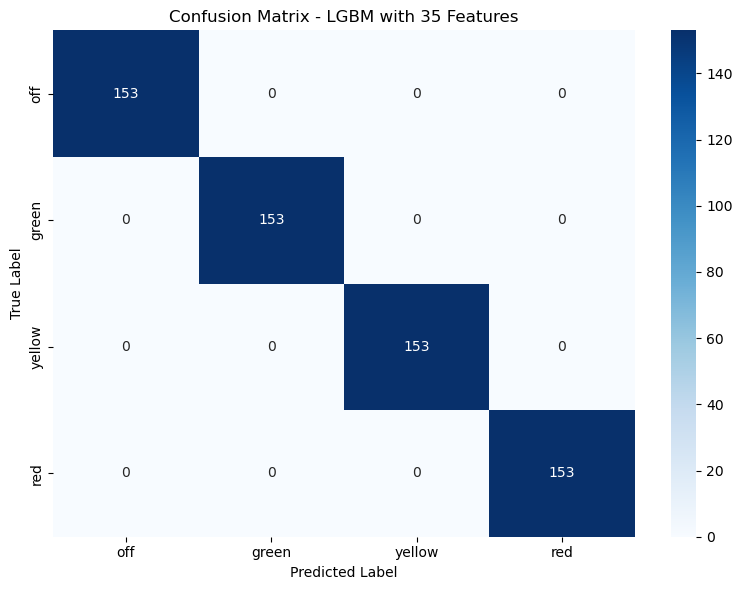

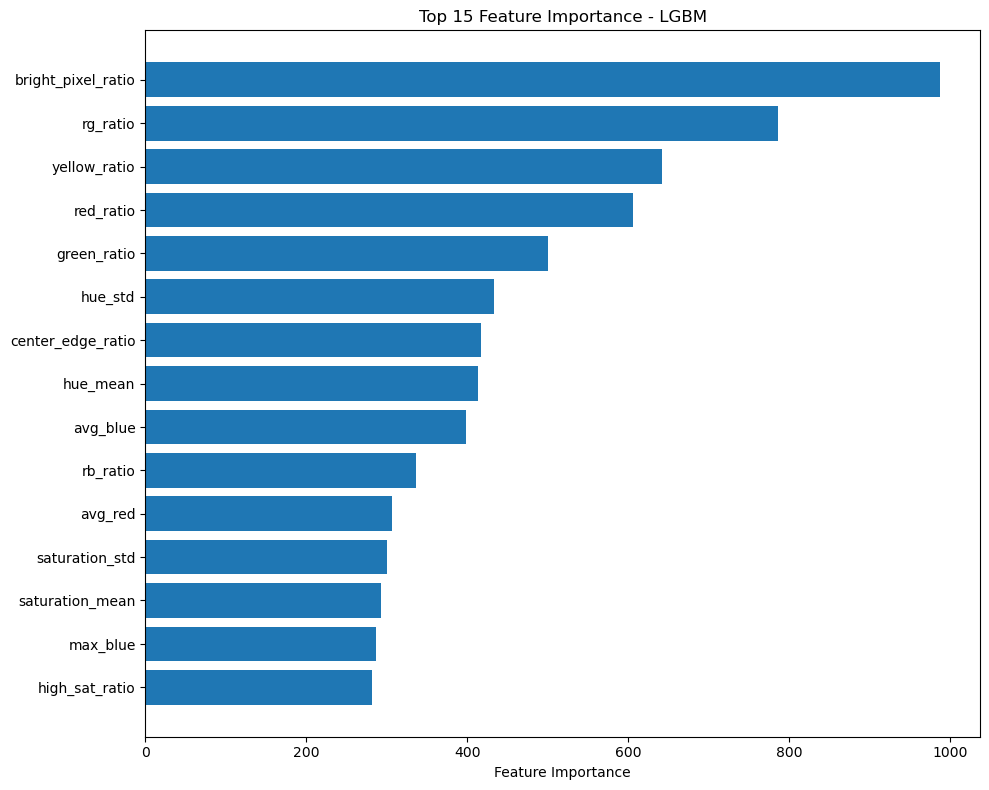


🎉 모델 훈련 완료!
📊 최종 테스트 정확도: 1.0000
📁 모델 파일: best_lgbm_model_35features.pkl

📋 다음 단계:
   1. detection.py에서 모델 파일명 변경
   2. 35개 특징 함수가 올바르게 작동하는지 테스트
   3. GUI와 통합 테스트


In [16]:
# 🤖 35개 특징으로 새로운 LGBM 모델 훈련
print("=" * 80)
print("🤖 LGBM 모델 훈련 (35개 확장된 특징)")
print("=" * 80)

import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

def train_lgbm_model(csv_file="led_features_for_training.csv"):
    """35개 특징으로 LGBM 모델 훈련"""
    
    print(f"📂 CSV 파일 로드: {csv_file}")
    
    # CSV 파일 로드
    df = pd.read_csv(csv_file)
    print(f"📊 데이터 형태: {df.shape}")
    print(f"📊 라벨 분포:")
    print(df['label'].value_counts().sort_index())
    
    # 특징과 라벨 분리
    feature_columns = [col for col in df.columns if col.startswith(('avg_', 'max_', 'std_', 'min_', 'green_', 'yellow_', 'red_', 'edge_', 'contour_', 'hue_', 'saturation_', 'value_', 'brightness_', 'rgb_', 'rg_', 'rb_', 'bright_', 'dark_', 'high_', 'center_', 'hotspot_', 'color_'))]
    
    print(f"🔍 감지된 특징 컬럼: {len(feature_columns)}개")
    print(f"📋 특징 목록:")
    for i, col in enumerate(feature_columns, 1):
        print(f"   {i:2d}. {col}")
    
    X = df[feature_columns]
    y = df['label']
    
    # 데이터 분할
    print(f"\n🔄 데이터 분할 중...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"📊 훈련 세트: {X_train.shape[0]}개")
    print(f"📊 테스트 세트: {X_test.shape[0]}개")
    
    # LGBM 모델 설정
    print(f"\n⚙️  LGBM 모델 설정...")
    lgbm_params = {
        'objective': 'multiclass',
        'num_class': 4,
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.1,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'random_state': 42
    }
    
    # 모델 훈련
    print(f"🚀 LGBM 모델 훈련 시작...")
    model = lgb.LGBMClassifier(**lgbm_params)
    model.fit(X_train, y_train)
    
    # 예측 및 평가
    print(f"🔮 모델 평가 중...")
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    
    print(f"\n📊 모델 성능:")
    print(f"   훈련 정확도: {train_accuracy:.4f}")
    print(f"   테스트 정확도: {test_accuracy:.4f}")
    
    # 분류 리포트
    print(f"\n📋 상세 분류 리포트:")
    label_names = ['off', 'green', 'yellow', 'red']
    print(classification_report(y_test, test_pred, target_names=label_names))
    
    # 혼동 행렬
    print(f"\n🔀 혼동 행렬:")
    cm = confusion_matrix(y_test, test_pred)
    print(cm)
    
    # 특징 중요도
    print(f"\n🎯 상위 10개 중요한 특징:")
    feature_importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    for i, (_, row) in enumerate(importance_df.head(10).iterrows()):
        print(f"   {i+1:2d}. {row['feature']:20s}: {row['importance']:.4f}")
    
    # 모델 저장
    model_path = "../ml/best_lgbm_model_35features.pkl"
    print(f"\n💾 모델 저장 중: {model_path}")
    try:
        joblib.dump(model, model_path)
        print(f"✅ 모델 저장 완료!")
    except Exception as e:
        print(f"⚠️  모델 저장 실패: {e}")
        # 현재 디렉토리에 저장 시도
        local_path = "best_lgbm_model_35features.pkl"
        joblib.dump(model, local_path)
        print(f"✅ 현재 디렉토리에 저장: {local_path}")
    
    # 혼동 행렬 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix - LGBM with 35 Features')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # 특징 중요도 시각화
    plt.figure(figsize=(10, 8))
    top_features = importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importance - LGBM')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return model, test_accuracy, importance_df

# 모델 훈련 실행
if 'csv_df' in globals() and csv_df is not None:
    print("✅ CSV 데이터가 준비되어 있습니다. 모델 훈련을 시작합니다.")
    
    trained_model, accuracy, feature_importance = train_lgbm_model("led_features_for_training.csv")
    
    print(f"\n🎉 모델 훈련 완료!")
    print(f"📊 최종 테스트 정확도: {accuracy:.4f}")
    print(f"📁 모델 파일: best_lgbm_model_35features.pkl")
    print(f"\n📋 다음 단계:")
    print(f"   1. detection.py에서 모델 파일명 변경")
    print(f"   2. 35개 특징 함수가 올바르게 작동하는지 테스트")
    print(f"   3. GUI와 통합 테스트")
    
else:
    print("❌ CSV 데이터가 없습니다. 먼저 이전 셀을 실행하세요.")

print("=" * 80)

In [ ]:
# ? 간단한 140개 특징 CSV 생성 (핵심만)
print("=" * 60)
print("? 140개 특징 CSV 생성")
print("=" * 60)

def create_simple_csv(data_dir="label", output_csv="led_features_140.csv"):
    """4가지 전처리로 140개 특징 CSV 생성 (간단 버전)"""
    
    label_map = {'off': 0, 'green': 1, 'yellow': 2, 'red': 3}
    
    # 140개 특징명 생성 (detection.py와 동일 순서)
    base_features = [
        'avg_brightness', 'max_brightness', 'std_brightness',
        'avg_red', 'avg_green', 'avg_blue', 
        'green_ratio', 'yellow_ratio', 'red_ratio',
        'edge_count', 'contour_area',
        'hue_mean', 'saturation_mean', 'value_mean',
        'min_brightness', 'brightness_range', 'brightness_median',
        'max_red', 'max_green', 'max_blue', 'rgb_dominance', 'rg_ratio', 'rb_ratio',
        'hue_std', 'saturation_std', 'saturation_max',
        'bright_pixel_ratio', 'dark_pixel_ratio', 'high_sat_ratio',
        'center_brightness', 'edge_brightness', 'center_edge_ratio',
        'hotspot_count', 'hotspot_ratio', 'color_uniformity'
    ]
    
    column_names = []
    for preprocessing in ['original', 'clahe', 'blur', 'hsv']:
        for feature in base_features:
            column_names.append(f"{preprocessing}_{feature}")
    
    print(f"? 생성할 특징: {len(column_names)}개")
    print(f"📂 데이터 폴더: {data_dir}")
    
    rows = []
    
    for label_name in tqdm(os.listdir(data_dir)):
        if label_name not in label_map:
            continue
            
        label_path = os.path.join(data_dir, label_name)
        if not os.path.isdir(label_path):
            continue
            
        label = label_map[label_name]
        
        for image_file in os.listdir(label_path):
            if not image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
                
            image_path = os.path.join(label_path, image_file)
            image = cv2.imread(image_path)
            
            if image is None:
                continue
                
            # 140개 특징 추출 (detection.py와 동일)
            features, _ = apply_parallel_preprocessing(image)
            
            if len(features) != 140:
                continue
                
            # CSV 행 생성
            row = features + [label, image_file, label_name]
            rows.append(row)
    
    # DataFrame 생성 및 저장
    columns = column_names + ['label', 'image_name', 'label_name']
    df = pd.DataFrame(rows, columns=columns)
    df.to_csv(output_csv, index=False)
    
    print(f"✅ CSV 생성 완료!")
    print(f"📊 샘플 수: {len(df)}")
    print(f"📊 라벨 분포: {df['label'].value_counts().sort_index().to_dict()}")
    print(f"📄 파일: {output_csv}")
    
    return df

# 실행
simple_df = create_simple_csv()

print("=" * 60)

🔄 독립적인 전처리별 특징 추출 (4가지 병렬 방식)
🚀 4가지 병렬 전처리 CSV 데이터셋 생성: label
🔍 추출된 총 특징 개수: 140개
🔍 전처리당 특징 개수: 35개
📋 4가지 전처리 방식:
   1. 원본 (리사이징만)
   2. CLAHE
   3. 가우시안 블러
   4. HSV 부스트
📋 생성된 컬럼명 예시:
   원본: original_avg_brightness, original_max_brightness, ...
   CLAHE: clahe_avg_brightness, clahe_max_brightness, ...
   블러: blur_avg_brightness, blur_max_brightness, ...
   HSV: hsv_avg_brightness, hsv_max_brightness, ...


  0%|          | 0/5 [00:00<?, ?it/s]


📂 처리 중: green 폴더


 20%|██        | 1/5 [00:02<00:10,  2.69s/it]


📂 처리 중: red 폴더


 60%|██████    | 3/5 [00:05<00:03,  1.61s/it]


📂 처리 중: yellow 폴더


 80%|████████  | 4/5 [00:07<00:01,  1.95s/it]


📂 처리 중: off 폴더


100%|██████████| 5/5 [00:10<00:00,  2.07s/it]



✅ 4가지 병렬 전처리 CSV 데이터셋 생성 완료!
📊 총 샘플 수: 3060
📊 총 특징 수: 140
📊 전처리별 특징 수: 35개씩
📊 라벨 분포:
label
0    765
1    765
2    765
3    765
Name: count, dtype: int64
📊 저장 위치: led_features_parallel_preprocessing.csv

📋 전처리별 특징 미리보기:

   ORIGINAL 전처리:
     특징 범위: original_avg_brightness ~ original_color_uniformity
     샘플값: [np.float64(131.2035) np.uint8(212) np.float64(40.10611284766949)]

   CLAHE 전처리:
     특징 범위: clahe_avg_brightness ~ clahe_color_uniformity
     샘플값: [np.float64(163.7922) np.uint8(245) np.float64(51.33913146090416)]

   BLUR 전처리:
     특징 범위: blur_avg_brightness ~ blur_color_uniformity
     샘플값: [np.float64(131.1925) np.uint8(211) np.float64(39.83574580386314)]

   HSV 전처리:
     특징 범위: hsv_avg_brightness ~ hsv_color_uniformity
     샘플값: [np.float64(127.2068) np.uint8(207) np.float64(48.93554979521534)]

🎯 생성된 4가지 병렬 전처리 CSV 정보:
   • 파일명: led_features_parallel_preprocessing.csv
   • 형태: (3060, 143)
   • 전처리 방식: 4가지 (원본, CLAHE, 블러, HSV)
   • 각 이미지당 특징 수: 140개
   • 특징명: 영어로 명명 (예: o

In [ ]:
# 🤖 간단한 LGBM 모델 훈련
print("=" * 60)
print("🤖 LGBM 모델 훈련")
print("=" * 60)

def train_simple_lgbm(csv_file="led_features_140.csv"):
    """간단한 LGBM 모델 훈련"""
    
    df = pd.read_csv(csv_file)
    print(f"📊 데이터: {df.shape}")
    
    # 특징과 라벨 분리
    feature_cols = [col for col in df.columns if col.endswith(('_avg_brightness', '_max_brightness', '_std_brightness', '_green_ratio', '_yellow_ratio', '_red_ratio'))]
    
    if len(feature_cols) == 0:  # 모든 특징 사용
        feature_cols = [col for col in df.columns if col.startswith(('original_', 'clahe_', 'blur_', 'hsv_'))]
    
    print(f"📊 사용할 특징: {len(feature_cols)}개")
    
    X = df[feature_cols]
    y = df['label']
    
    # 훈련/테스트 분할
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # LGBM 모델 훈련
    import lightgbm as lgb
    model = lgb.LGBMClassifier(objective='multiclass', num_class=4, random_state=42)
    model.fit(X_train, y_train)
    
    # 성능 평가
    from sklearn.metrics import accuracy_score
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    
    print(f"📊 훈련 정확도: {train_acc:.3f}")
    print(f"📊 테스트 정확도: {test_acc:.3f}")
    
    # 모델 저장
    import joblib
    model_path = "../ml/best_lgbm_model_140features.pkl"
    try:
        joblib.dump(model, model_path)
        print(f"✅ 모델 저장: {model_path}")
    except:
        local_path = "best_lgbm_model_140features.pkl"
        joblib.dump(model, local_path)
        print(f"✅ 모델 저장: {local_path}")
    
    return model

# 실행
if 'simple_df' in locals():
    simple_model = train_simple_lgbm()
else:
    print("❌ 먼저 CSV를 생성하세요")

print("=" * 60)

🤖 LGBM 모델 훈련 (140개 병렬 전처리 특징)
✅ 140개 특징 CSV 데이터가 준비되어 있습니다. 모델 훈련을 시작합니다.
📂 CSV 파일 로드: led_features_parallel_preprocessing.csv
📊 데이터 형태: (3060, 143)
📊 라벨 분포:
label
0    765
1    765
2    765
3    765
Name: count, dtype: int64
🔍 감지된 특징 컬럼: 140개
📋 전처리별 특징 개수:
   original: 35개
   clahe: 35개
   blur: 35개
   hsv: 35개

🔄 데이터 분할 중...
📊 훈련 세트: 2448개
📊 테스트 세트: 612개

⚙️  LGBM 모델 설정...
🚀 LGBM 모델 훈련 시작...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] b

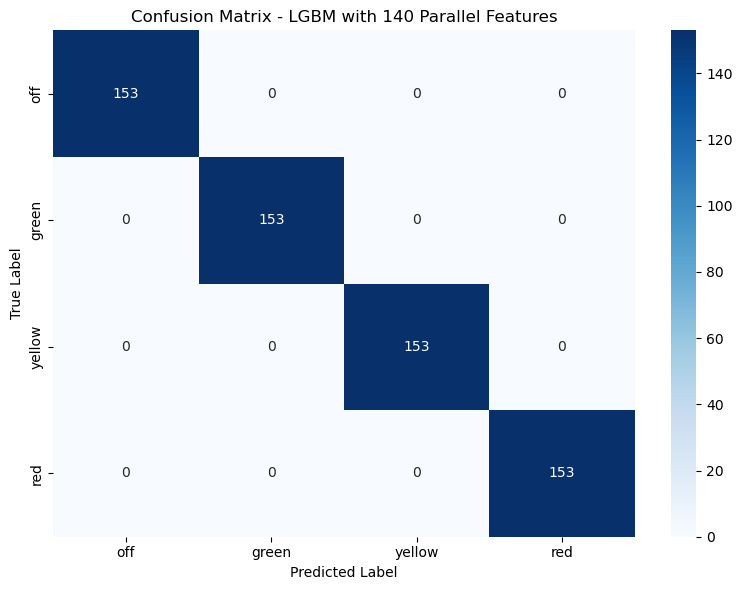

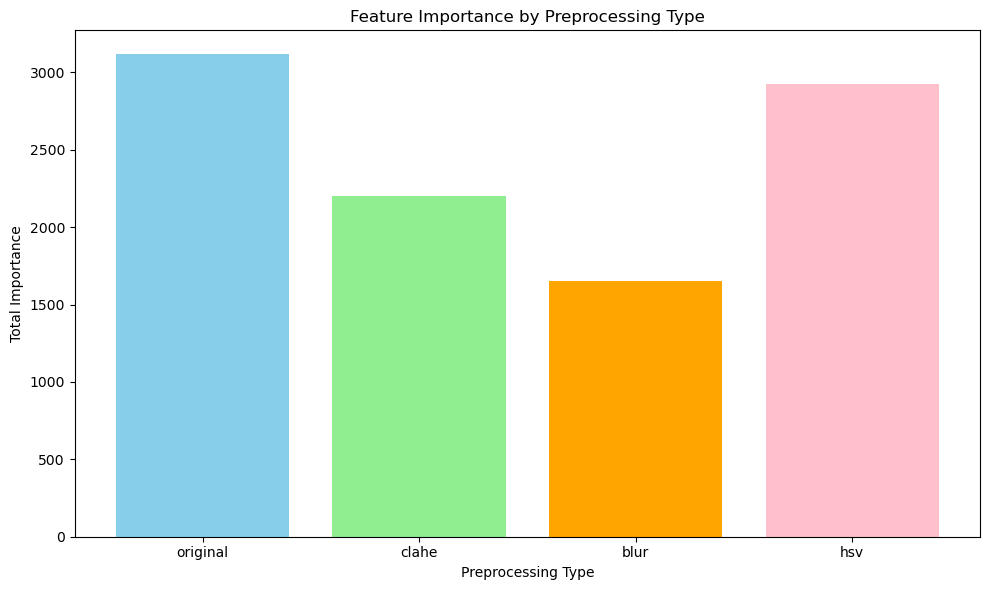

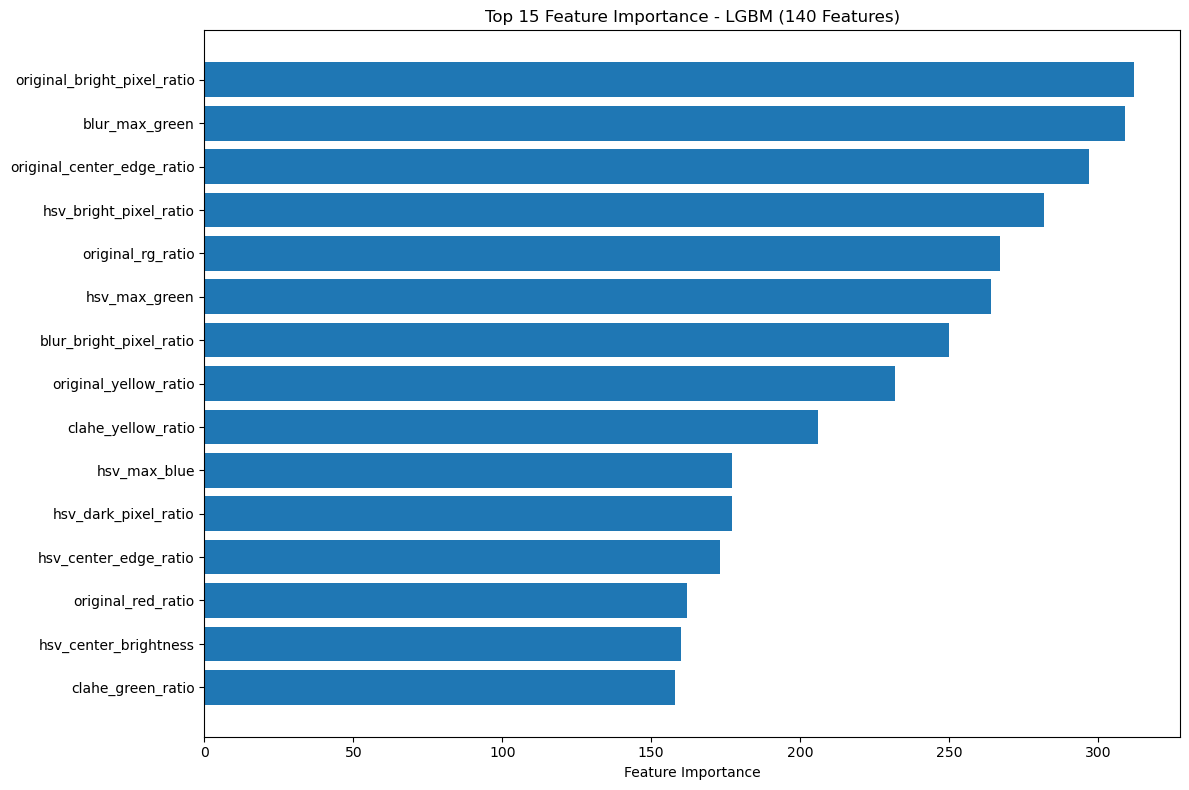


🎉 140개 특징 모델 훈련 완료!
📊 최종 테스트 정확도: 1.0000
📁 모델 파일: best_lgbm_model_140features.pkl

📊 모델 성능 비교:
   35개 특징 모델: 1.0000
   140개 특징 모델: 1.0000
   성능 향상: +0.00%p

📋 다음 단계:
   1. detection.py에서 140개 특징 모델 사용
   2. GUI와 통합 테스트
   3. 실제 이미지로 성능 검증


In [21]:
# 🤖 140개 특징으로 새로운 LGBM 모델 훈련
print("=" * 80)
print("🤖 LGBM 모델 훈련 (140개 병렬 전처리 특징)")
print("=" * 80)

import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

def train_lgbm_model_140features(csv_file="led_features_parallel_preprocessing.csv"):
    """140개 병렬 전처리 특징으로 LGBM 모델 훈련"""
    
    print(f"📂 CSV 파일 로드: {csv_file}")
    
    # CSV 파일 로드
    df = pd.read_csv(csv_file)
    print(f"📊 데이터 형태: {df.shape}")
    print(f"📊 라벨 분포:")
    print(df['label'].value_counts().sort_index())
    
    # 140개 특징 컬럼 분리 (original_, clahe_, blur_, hsv_로 시작하는 컬럼들)
    feature_columns = [col for col in df.columns if col.startswith(('original_', 'clahe_', 'blur_', 'hsv_'))]
    
    print(f"🔍 감지된 특징 컬럼: {len(feature_columns)}개")
    print(f"📋 전처리별 특징 개수:")
    
    # 전처리별 특징 개수 확인
    preprocessing_types = ['original', 'clahe', 'blur', 'hsv']
    for proc_type in preprocessing_types:
        count = len([col for col in feature_columns if col.startswith(f"{proc_type}_")])
        print(f"   {proc_type}: {count}개")
    
    X = df[feature_columns]
    y = df['label']
    
    # 데이터 분할
    print(f"\n🔄 데이터 분할 중...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"📊 훈련 세트: {X_train.shape[0]}개")
    print(f"📊 테스트 세트: {X_test.shape[0]}개")
    
    # LGBM 모델 설정
    print(f"\n⚙️  LGBM 모델 설정...")
    lgbm_params = {
        'objective': 'multiclass',
        'num_class': 4,
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.1,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'random_state': 42
    }
    
    # 모델 훈련
    print(f"🚀 LGBM 모델 훈련 시작...")
    model = lgb.LGBMClassifier(**lgbm_params)
    model.fit(X_train, y_train)
    
    # 예측 및 평가
    print(f"🔮 모델 평가 중...")
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    
    print(f"\n📊 모델 성능:")
    print(f"   훈련 정확도: {train_accuracy:.4f}")
    print(f"   테스트 정확도: {test_accuracy:.4f}")
    
    # 분류 리포트
    print(f"\n📋 상세 분류 리포트:")
    label_names = ['off', 'green', 'yellow', 'red']
    print(classification_report(y_test, test_pred, target_names=label_names))
    
    # 혼동 행렬
    print(f"\n🔀 혼동 행렬:")
    cm = confusion_matrix(y_test, test_pred)
    print(cm)
    
    # 전처리별 중요도 분석
    print(f"\n🎯 전처리별 중요도 분석:")
    feature_importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': feature_importance
    })
    
    # 전처리별 중요도 합계
    preprocessing_importance = {}
    for proc_type in preprocessing_types:
        proc_features = [col for col in feature_columns if col.startswith(f"{proc_type}_")]
        proc_importance = importance_df[importance_df['feature'].isin(proc_features)]['importance'].sum()
        preprocessing_importance[proc_type] = proc_importance
        print(f"   {proc_type}: {proc_importance:.4f}")
    
    # 상위 중요한 특징
    print(f"\n🎯 상위 15개 중요한 특징:")
    top_features = importance_df.sort_values('importance', ascending=False).head(15)
    for i, (_, row) in enumerate(top_features.iterrows()):
        print(f"   {i+1:2d}. {row['feature']:30s}: {row['importance']:.4f}")
    
    # 모델 저장
    model_path = "../ml/best_lgbm_model_140features.pkl"
    print(f"\n💾 모델 저장 중: {model_path}")
    try:
        joblib.dump(model, model_path)
        print(f"✅ 모델 저장 완료!")
    except Exception as e:
        print(f"⚠️  모델 저장 실패: {e}")
        # 현재 디렉토리에 저장 시도
        local_path = "best_lgbm_model_140features.pkl"
        joblib.dump(model, local_path)
        print(f"✅ 현재 디렉토리에 저장: {local_path}")
    
    # 혼동 행렬 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix - LGBM with 140 Parallel Features')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # 전처리별 중요도 시각화
    plt.figure(figsize=(10, 6))
    proc_names = list(preprocessing_importance.keys())
    proc_values = list(preprocessing_importance.values())
    plt.bar(proc_names, proc_values, color=['skyblue', 'lightgreen', 'orange', 'pink'])
    plt.xlabel('Preprocessing Type')
    plt.ylabel('Total Importance')
    plt.title('Feature Importance by Preprocessing Type')
    plt.tight_layout()
    plt.show()
    
    # 상위 특징 중요도 시각화
    plt.figure(figsize=(12, 8))
    top_15_features = top_features.head(15)
    plt.barh(range(len(top_15_features)), top_15_features['importance'])
    plt.yticks(range(len(top_15_features)), top_15_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importance - LGBM (140 Features)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return model, test_accuracy, importance_df, preprocessing_importance

# 모델 훈련 실행
if 'parallel_csv_df' in globals() and parallel_csv_df is not None:
    print("✅ 140개 특징 CSV 데이터가 준비되어 있습니다. 모델 훈련을 시작합니다.")
    
    trained_model_140, accuracy_140, feature_importance_140, proc_importance = train_lgbm_model_140features("led_features_parallel_preprocessing.csv")
    
    print(f"\n🎉 140개 특징 모델 훈련 완료!")
    print(f"📊 최종 테스트 정확도: {accuracy_140:.4f}")
    print(f"📁 모델 파일: best_lgbm_model_140features.pkl")
    
    # 35개 vs 140개 특징 성능 비교
    print(f"\n📊 모델 성능 비교:")
    if 'accuracy' in globals():
        print(f"   35개 특징 모델: {accuracy:.4f}")
        print(f"   140개 특징 모델: {accuracy_140:.4f}")
        improvement = (accuracy_140 - accuracy) * 100
        print(f"   성능 향상: {improvement:+.2f}%p")
    
    print(f"\n📋 다음 단계:")
    print(f"   1. detection.py에서 140개 특징 모델 사용")
    print(f"   2. GUI와 통합 테스트")
    print(f"   3. 실제 이미지로 성능 검증")
    
else:
    print("❌ 140개 특징 CSV 데이터가 없습니다. 먼저 이전 셀을 실행하세요.")

print("=" * 80)